**Desarrollado por:** Javier Fernando Botía Valderrama

*Docente del Departamento de Ingeniería de Sistemas*

**Materia:** Análisis Avanzado de Datos

**Departamento:** Ingeniería Aeroespacial

**Facultad de Ingeniería - Universidad de Antioquia**

# Métodos Básicos para la Detección y Eliminación de Datos Atípicos

In [ ]:
import pandas as pd
import numpy as np
import requests
import io
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor # Algoritmo LOF
from scipy.special import entr # Entropía de Shannon
from scipy.stats import multivariate_normal # Modelo de distribución gaussiana multivariable
from sklearn.covariance import EllipticEnvelope # Estimación de Covarianza
from scipy.stats import median_abs_deviation # MAD
from scipy.stats import iqr # Interquartile range
import matplotlib

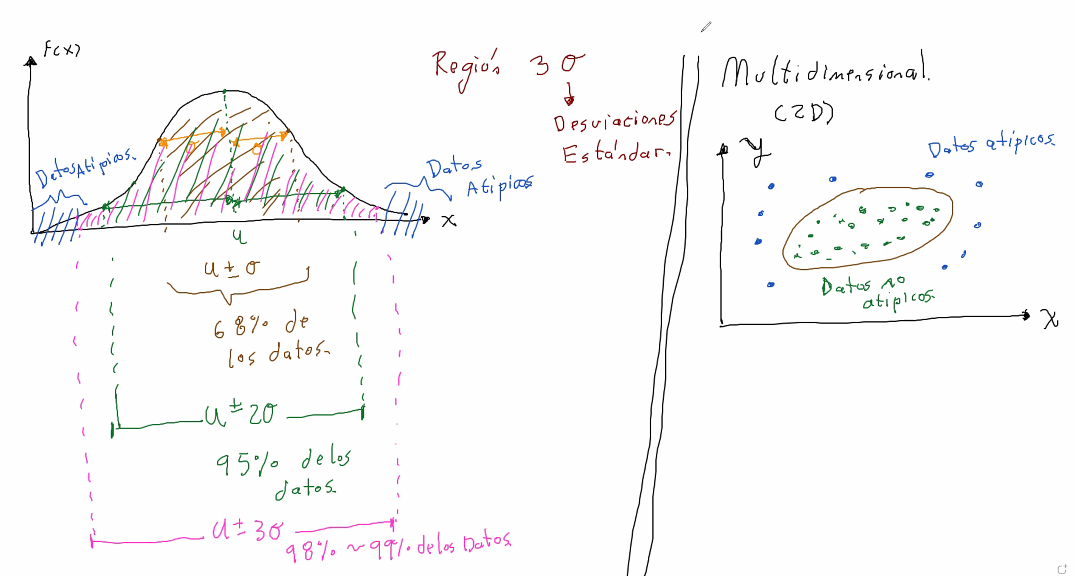

In [ ]:
from IPython.display import Image
Image(filename="datos_atipicos.png")

**Datos atípicos u outliers:**  Un *outlier* es un punto por el cual esta alejado desde el valor predicho por un modelo. Este tipo de datos se generan por diversas razones tales como almacenamiento incorrecto de la base de datos o el ruido de los sensores que generan lecturas erróneas, etc. Por lo general, los datos atípicos pueden tener pocos efectos en el desempeño de un modelo si el error que genera es pequeño o poco representativo para una predicción o una estimación. Sin embargo, si hay un porcentaje alto de la base de datos que son atípicos, el error puede incrementar abruptamente y generar una disminución el desempeño de un modelo de regresión o de clasificación, etc...

**Base de datos:** 

This dataset was generated for use on 'Prediction of Motor Failure Time Using An Artificial Neural Network' project (DOI: 10.3390/s19194342). A cooler fan with weights on its blades was used to generate vibrations. To this fan cooler was attached an accelerometer to collect the vibration data. With this data, motor failure time predictions were made, using an artificial neural networks. To generate three distinct vibration scenarios, the weights were distributed in three different ways: 1) 'red' - normal configuration: two weight pieces positioned on neighboring blades; 2) 'blue' - perpendicular configuration: two weight pieces positioned on blades forming a 90$°$ angle; 3) 'green' - opposite configuration: two weight pieces positioned on opposite blades.

*Devices used*:

Akasa AK-FN059 12cm Viper cooling fan (Generate the vibrations)
MMA8452Q accelerometer (Measure vibration)

*Data collection method*:

17 rotation speeds were set up, ranging from 20% to 100% of the cooler maximum speed at 5% intervals; for the three weight distribution configurations in the cooler blades. Note that the Akasa AK-FN059 cooler has 1900 rpm of max rotation speed.

The vibration measurements were collected at a frequency of 20 ms for 1 min for each percentage, generating 3000 records per speed. Thus, in total, 153.000 vibration records were collected from the simulation model.

*Columns:*

*   wconfid: Weight Configuration ID (1 - 'red' - normal configuration; 2 - 'blue' - perpendicular configuration; 3 - 'green' - opposite configuration)
*   pctid: Cooler Fan RPM Speed Percentage ID (20 means 20%, and so on).
*   x: Accelerometer x value.
*   y: Accelerometer y value.
*   z: Accelerometer z value.

In [ ]:
url = "https://raw.githubusercontent.com/javierfernandobotia/AnalisisAvanzadoDatos/main/accelerometer.csv"
download = requests.get(url).content
data = pd.read_csv(io.StringIO(download.decode('utf-8')), sep=',',
                     decimal = ',')
# Esimportante codificarlo a utf-8
display(data.head(20))

,wconfid,pctid,x,y,z
0,1,20,1.004,0.090,-0.125
1,1,20,1.004,-0.043,-0.125
2,1,20,0.969,0.090,-0.121
3,1,20,0.973,-0.012,-0.137
4,1,20,1.000,-0.016,-0.121
5,1,20,0.961,0.082,-0.121
6,1,20,0.973,-0.055,-0.109
7,1,20,1.000,0.012,-0.133
8,1,20,0.969,-0.102,-0.141
9,1,20,0.973,-0.059,-0.125


## Visualización de los Datos Atípicos con el diagrama de cajas

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153000 entries, 0 to 152999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   wconfid  153000 non-null  int64 
 1   pctid    153000 non-null  int64 
 2   x        153000 non-null  object
 3   y        153000 non-null  object
 4   z        153000 non-null  object
dtypes: int64(2), object(3)
memory usage: 5.8+ MB


Convertimos las variables x, y, z en datos tipo float64.

In [ ]:
data['x'] = data['x'].astype(float)
data['y'] = data['y'].astype(float)
data['z'] = data['z'].astype(float)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153000 entries, 0 to 152999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   wconfid  153000 non-null  int64  
 1   pctid    153000 non-null  int64  
 2   x        153000 non-null  float64
 3   y        153000 non-null  float64
 4   z        153000 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 5.8 MB


Generando un reporte estadístico de las variables:

In [ ]:
data.describe()

,wconfid,pctid,x,y,z
count,153000.000000,153000.000000,153000.000000,153000.000000,153000.000000
mean,2.000000,60.000000,0.995622,0.005351,-0.117769
std,0.816499,24.494977,0.773958,0.742602,0.517008
min,1.000000,20.000000,-8.000000,-8.000000,-5.867000
25%,1.000000,40.000000,0.945000,-0.078000,-0.172000
50%,2.000000,60.000000,0.992000,0.008000,-0.125000
75%,3.000000,80.000000,1.039000,0.105000,-0.066000
max,3.000000,100.000000,7.996000,7.996000,6.086000


Generando el diagrama de cajas:

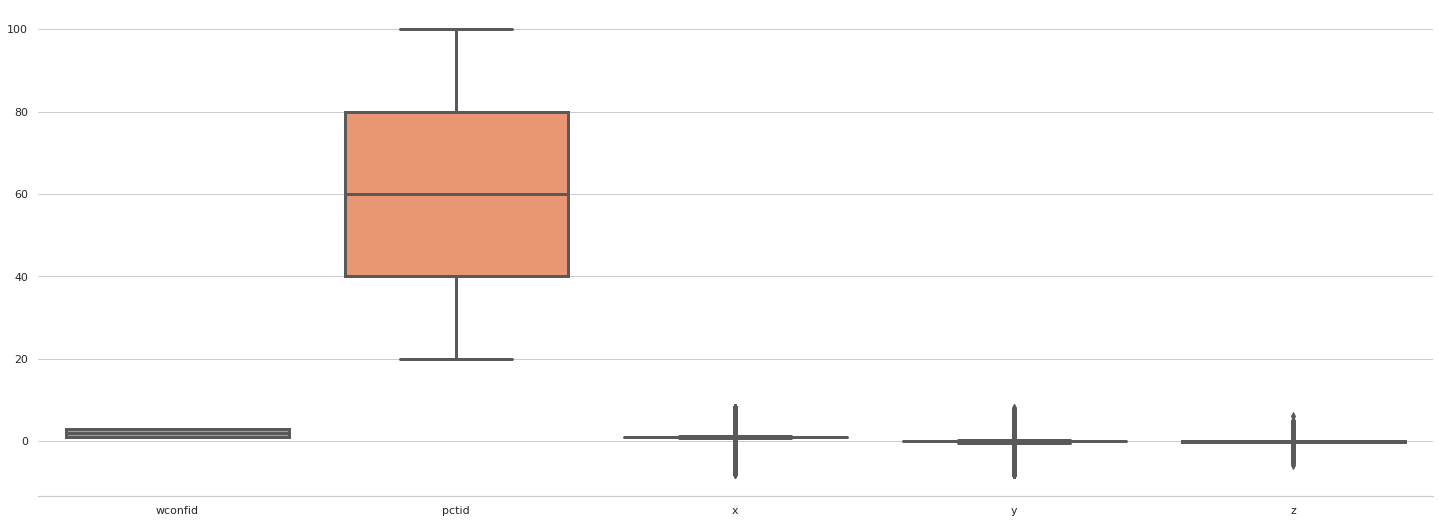

In [ ]:
sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = data, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

Normalizando los datos para mejorar la visualización del diagrama de cajas:

In [ ]:
MinMax = MinMaxScaler(copy=True, feature_range=(0, 1)) # Método MinMax con valores entre 0 y 1
nombres = data.columns
Datos_Min_Max = MinMax.fit_transform(data) # Transformación de los nuevos datos con una escala MinMax
Datos_Min_Max = pd.DataFrame(Datos_Min_Max, columns = nombres)

In [ ]:
Datos_Min_Max.describe()

,wconfid,pctid,x,y,z
count,153000.00000,153000.000000,153000.000000,153000.000000,153000.000000
mean,0.50000,0.500000,0.562367,0.500460,0.480986
std,0.40825,0.306187,0.048384,0.046424,0.043253
min,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.250000,0.559202,0.495249,0.476449
50%,0.50000,0.500000,0.562141,0.500625,0.480381
75%,1.00000,0.750000,0.565079,0.506689,0.485317
max,1.00000,1.000000,1.000000,1.000000,1.000000


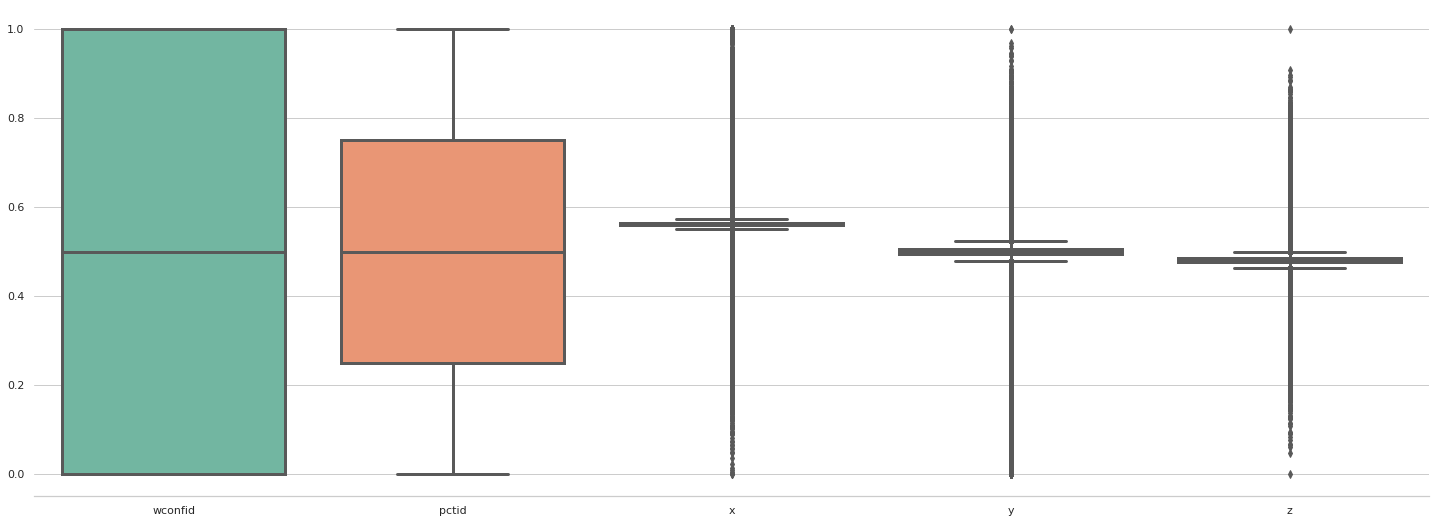

In [ ]:
sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = Datos_Min_Max, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

Se observa que las dos primeras columnas, *wconfid* y *pctid*, no tienen datos atípicos considerable pero las columnas *x*, *y*, *z*, tienen presencia de datos atípicos en ambos cuartiles (por debajo de 25% y por encima de 75 %). Por consiguiente, vamos a detectar y eliminar los datos atípicos sin sacrificar hasta lo posible la información que puedan ofrecer las variables *x*, *y*, *z*. 

## Algoritmo LOF (Local Outlier Factor)

Es un método de detección de outilers basado en una búsqueda local de datos atípicos llamado **factor atípico local o LOF**. Al usar LOF, se calcula la desviación local de la densidad de cada muestra con respecto a sus vecinos más cercanos. Por lo general, se utiliza una métrica de distancia entre una muestra y los vecinos más cercanos de forma local, donde una distancia más grande de un vecino con respecto a una muestra se considera como dato atípico. 


**Notas**
- Capaz de identificar los datos atípicos a traves de unos radios
- Calcular desviaciones estandar de cada uno de los datos
- Se calcula una distancia euclidiana a partir de las desviaciones estándar
- Con esas distancias se calcula una región
- Radio de detección -> qué parte de los datos son atípicos y cuáles no
- Utiliza el mismo concepto de los vecinos más cercanos

In [ ]:
LOF = LocalOutlierFactor(n_neighbors = 5, algorithm = 'auto', contamination = 'auto', metric = 'euclidean') 
# OJO, usar un número de vecinos más cercano con números impares.

Filtrado = LOF.fit_predict(Datos_Min_Max) # Se realiza la predicción de los datos atípicos

NOF = LOF.negative_outlier_factor_ # Detecta los valores positivos y negativos (residuos). Si los valores son grandes, entonces son valores no atípicos y por lo general, son valores cercanos a -1.
                                   # Si los valores son positivos y grandes y cercanos a 1, entonces son valores atípicos. La opción negative_outlier_dactor_ calcula dichos valores por 
                                   # la media de la relación entre la densidad local de una muestra y las de sus vecinos más cercanos.

radio_outiler = (NOF.max() - NOF)/(NOF.max() - NOF.min()) # radio de detección de datos atípicos
ground_truth = np.ones(len(Datos_Min_Max), dtype = int) 
# Se recomienda para luego comparar que datos es o no atípico (genera un vector de 1 o -1)
n_errors = (Filtrado != ground_truth).sum() # número de datos atípicos

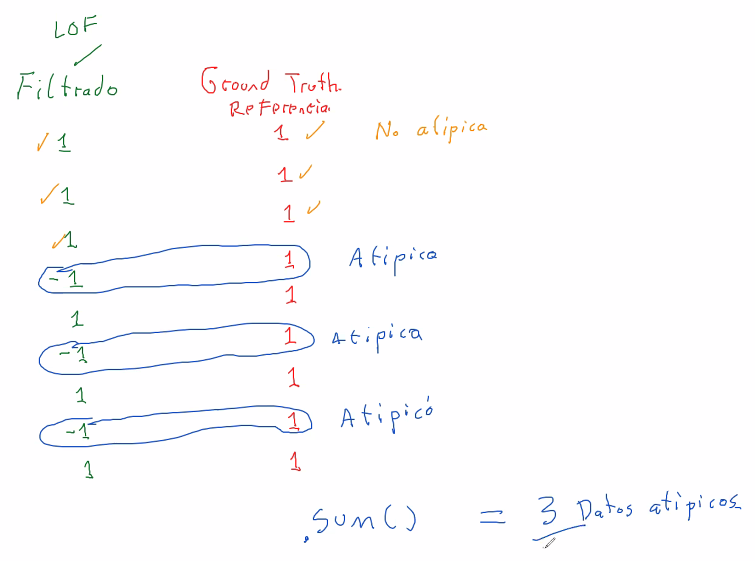

In [ ]:
from IPython.display import Image
Image(filename="filtrado_ground.png")

In [ ]:
print("Detección: ", Filtrado)
print("Factores atípicos negativos: ", NOF)
print("Número de muestras o filas con datos atípicos: ", n_errors)

Detección:  [1 1 1 ... 1 1 1]
Factores atípicos negativos:  [-1.06320122 -0.97597487 -0.97905    ... -0.95174656 -1.14236594
 -0.94374553]
Número de muestras o filas con datos atípicos:  2581


Observemos como se visualiza la identificación de los datos atípicos, analizando dos características de nuestra base de datos

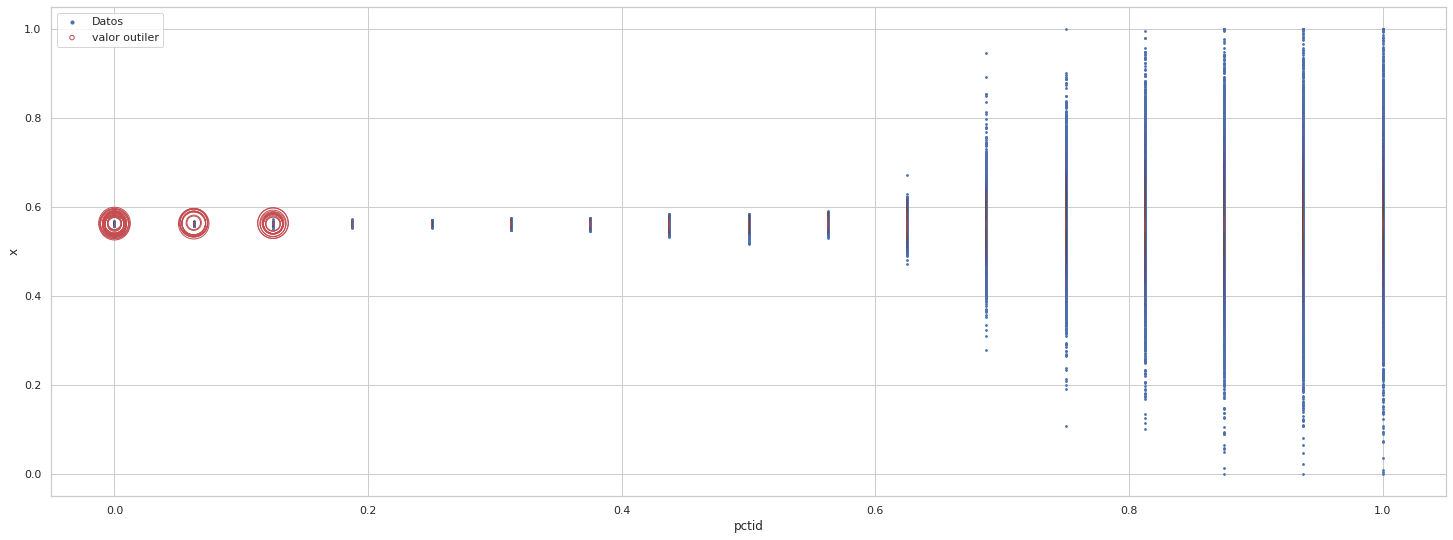

In [ ]:
plt.scatter(Datos_Min_Max['pctid'], Datos_Min_Max['x'], color='b', s=3, label='Datos')
plt.scatter(Datos_Min_Max['pctid'], Datos_Min_Max['x'], s=1000 * radio_outiler, edgecolors='r', facecolors='none', label='valor outiler')
plt.axis('tight')
plt.xlabel('pctid')
plt.ylabel('x')
legend = plt.legend(loc = 'upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

**Notas**
Aumentar o disminuir los vecinos más cercanos amplia o disminuye la detección de datos atípicos

Ahora, vamos a eliminar las muestras o filas de la base de datos donde el algoritmo LOF identifico como datos atípicos

In [ ]:
pos = np.where(Filtrado == ground_truth) # Se identifican en que muestras o filas de nuestra base de datos hay presencia de datos atípicos
pos = np.asarray(pos)
pos = np.hstack(pos)
datos_sin_outilers_LOF = Datos_Min_Max.loc[pos, :]
print("Número de muestras sin outilers:", datos_sin_outilers_LOF.shape[0])
display(datos_sin_outilers_LOF)

Número de muestras sin outilers: 150419


,wconfid,pctid,x,y,z
0,0.0,0.0,0.562891,0.505751,0.480381
1,0.0,0.0,0.562891,0.497437,0.480381
2,0.0,0.0,0.560703,0.505751,0.480716
3,0.0,0.0,0.560953,0.499375,0.479378
4,0.0,0.0,0.562641,0.499125,0.480716
...,...,...,...,...,...
152995,1.0,1.0,0.565829,0.505751,0.468920
152996,1.0,1.0,0.557514,0.502563,0.480047
152997,1.0,1.0,0.572393,0.494249,0.471848
152998,1.0,1.0,0.558515,0.512816,0.476449


In [ ]:
print(Datos_Min_Max.shape) # Tamaño de los datos originales
print(datos_sin_outilers_LOF.shape) # Tamañno de los datos sin outliers 

(153000, 5)
(150419, 5)


¿Qué cambios se observan en el diagrama de cajas con la eliminación de datos atípicos basado en el algoritmo LOF?

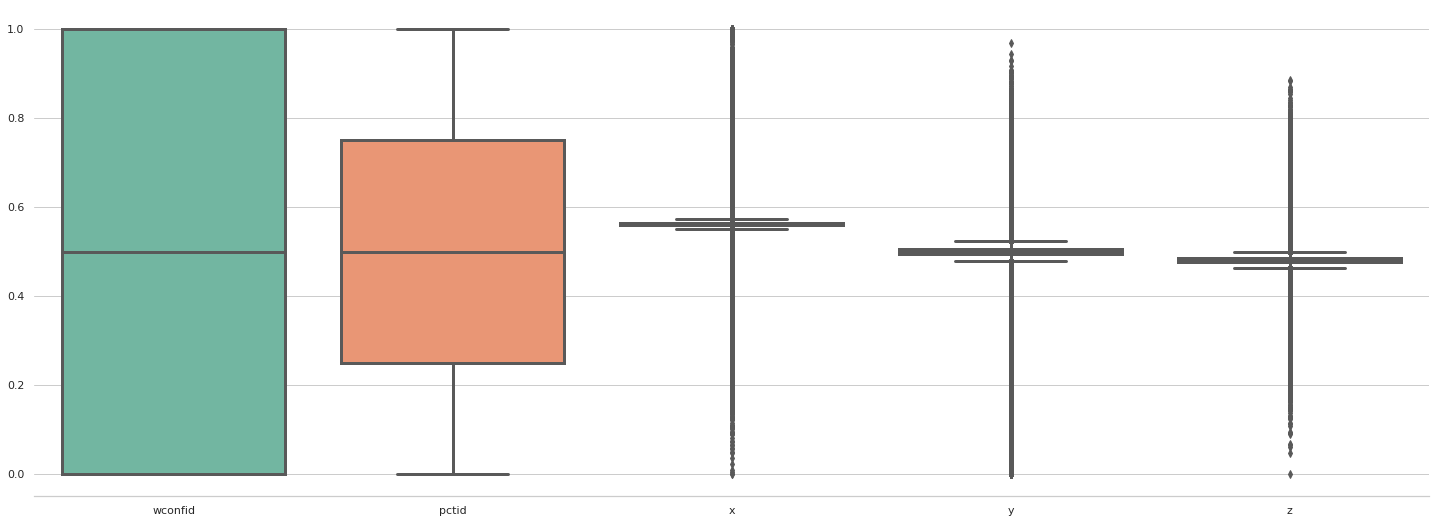

In [ ]:
sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = datos_sin_outilers_LOF, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

Para determinar si hay cambios considerables o no en la información de los datos, una estrategía es calcular el valor de la entropía en cada variable para comparar la información de los datos originales con respecto a la información de los datos con eliminación de datos atípicos (*Nota*: Solo se aplica con las características con datos cuantitativos):

In [ ]:
H_1 = entr(Datos_Min_Max[['x','y','z']])
H_2 = entr(datos_sin_outilers_LOF[['x','y','z']])

entropia_normalizada_1 = H_1.sum()/Datos_Min_Max.shape[0]
entropia_normalizada_2 = H_2.sum()/datos_sin_outilers_LOF.shape[0]

entropia_normalizada_1 = pd.DataFrame(entropia_normalizada_1, index = None, columns = ['Entropia Original'])
entropia_normalizada_2 = pd.DataFrame(entropia_normalizada_2, index = None, columns = ['Entropia LOF'])
Comparacion_entropias = pd.concat([entropia_normalizada_1, entropia_normalizada_2], axis = 1)

display(Comparacion_entropias)

,Entropia Original,Entropia LOF
x,0.321535,0.321538
y,0.344003,0.344028
z,0.350070,0.350089


Al comparar ambos casos, se concluye que el algoritmo LOF conservó la cantidad de información original de la base de datos.

## Rango intercuartil para detección de datos atípicos

El método de rango intercuartil es un método de detección de datos atípicos a partir de la diferencia entre el primer (25%) y el tercer cuartil (75%), el cual permite cubrir el 50% de los datos. 

$IQR = Q3 - Q1$

In [ ]:
IQR = iqr(Datos_Min_Max, axis = 0, rng = (25, 75), interpolation = 'midpoint')
print(IQR)

[1.         0.5        0.00587647 0.01144036 0.00886807]


Ahora, calculamos la *desviación cuartil*, el cual es la mitad del IQR:

In [ ]:
DC = IQR/2
print(DC)

[0.5        0.25       0.00293823 0.00572018 0.00443403]


La desviación cuartil nos permite observar que región de los datos está por fuera del IQR (Se puede visualizar con el diagrama de cajas). Ahora, vamos a calcular los límites intercuatiles el cual es $Q1 - 1.5*IQR$ y $Q3 + 1.5*IQR$. El valor 1.5 permite establecer una distancia entre el cuartil Q1 y Q3 con respecto al extremo superior e inferior de una caja que representa los datos.

In [ ]:
Q1 = np.percentile(Datos_Min_Max, 25, axis = 0, interpolation = 'midpoint')
Q3 = np.percentile(Datos_Min_Max, 75, axis = 0, interpolation = 'midpoint')

Min_Limite = Q1 - 1.5*IQR
Max_Limite = Q3 + 1.5*IQR

print("Límites inferiores = ", Min_Limite)
print("\n")
print("Límites superiores = ", Max_Limite)

Límites inferiores =  [-1.5        -0.5         0.5503876   0.47808827  0.46314733]


Límites superiores =  [2.5        1.5        0.57389347 0.52384971 0.49861959]


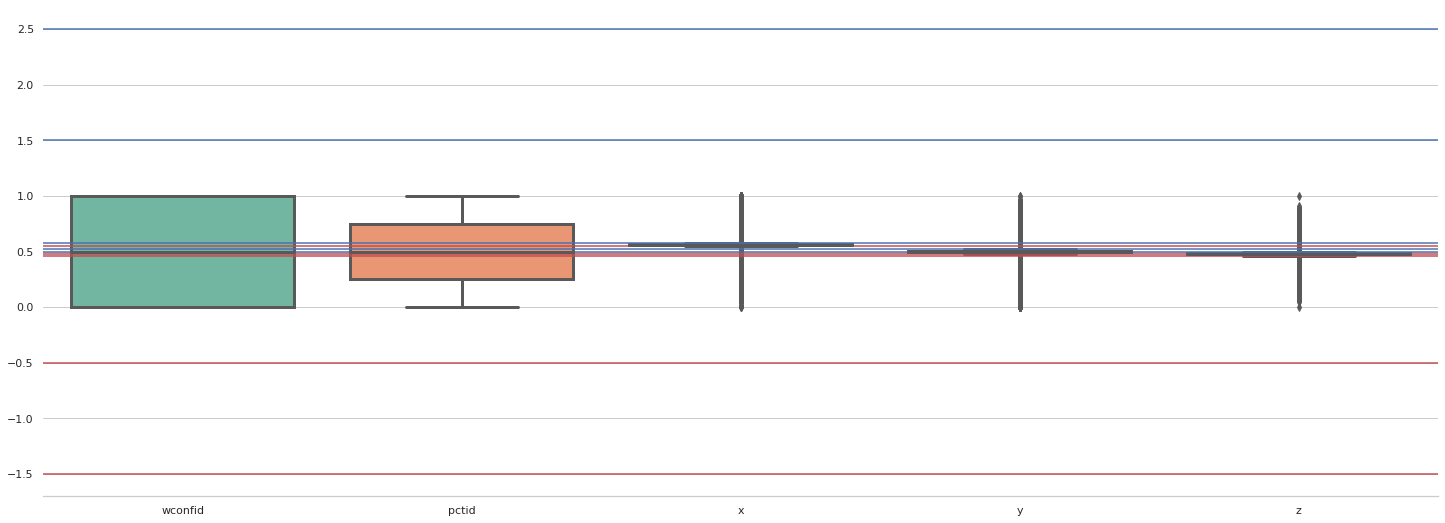

In [ ]:
sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = Datos_Min_Max, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot

for m in range(len(IQR)):
  plt.axhline(Min_Limite[m], color = 'r')
  plt.axhline(Max_Limite[m], color = 'b')

sns.despine(left=True)

In [ ]:
datos_atipicos_wconfid = []
datos_atipicos_pctid = []
datos_atipicos_x = []
datos_atipicos_y = []
datos_atipicos_z = []

pos_atipicos_wconfid = []
pos_atipicos_pctid = []
pos_atipicos_x = []
pos_atipicos_y = []
pos_atipicos_z = []

for n in range(Datos_Min_Max.shape[0]):
  if Datos_Min_Max.iloc[n,0] < Min_Limite[0] or Datos_Min_Max.iloc[n,0] > Max_Limite[0]:
     datos_atipicos_wconfid.append(Datos_Min_Max.iloc[n,0])
     pos_atipicos_wconfid.append(n)
  if Datos_Min_Max.iloc[n,1] < Min_Limite[1] or Datos_Min_Max.iloc[n,1] > Max_Limite[1]:
     datos_atipicos_pctid.append(Datos_Min_Max.iloc[n,1])
     pos_atipicos_pctid.append(n)
  if Datos_Min_Max.iloc[n,2] < Min_Limite[2] or Datos_Min_Max.iloc[n,2] > Max_Limite[2]:
     datos_atipicos_x.append(Datos_Min_Max.iloc[n,2])
     pos_atipicos_x.append(n)
  if Datos_Min_Max.iloc[n,3] < Min_Limite[3] or Datos_Min_Max.iloc[n,3] > Max_Limite[3]:
     datos_atipicos_y.append(Datos_Min_Max.iloc[n,3])
     pos_atipicos_y.append(n)
  if Datos_Min_Max.iloc[n,4] < Min_Limite[4] or Datos_Min_Max.iloc[n,4] > Max_Limite[4]:
     datos_atipicos_z.append(Datos_Min_Max.iloc[n,4])
     pos_atipicos_z.append(n)

Numero_datos_atipicos = [len(datos_atipicos_wconfid), len(datos_atipicos_pctid), len(datos_atipicos_x), 
                         len(datos_atipicos_y), len(datos_atipicos_z)]

reporte = pd.DataFrame(Numero_datos_atipicos, index = nombres, columns = ['Número de Datos Atípicos'])
display(reporte)  

,Número de Datos Atípicos
wconfid,0
pctid,0
x,38169
y,30135
z,43205


¿Cómo eliminar los datos atípicos si las columnas $x$, $y$, $z$, tienen diferentes número de datos atípicos? Una estrategía es localizar las posiciones donde coincidan los datos atípicos de las tres columnas mencionadas.

In [ ]:
Posiciones_coinciden = list(set(pos_atipicos_x) & set(pos_atipicos_y) & set(pos_atipicos_z))
print(Posiciones_coinciden)

[32769, 98306, 32771, 98307, 98308, 98312, 32779, 98316, 98318, 98319, 32785, 98321, 98322, 32788, 98323, 98324, 98325, 32792, 98329, 98332, 98333, 32799, 98335, 98336, 98337, 98338, 98340, 32806, 98342, 98343, 98344, 32811, 98347, 98348, 98350, 98353, 98354, 98355, 98356, 98357, 98359, 98360, 98365, 98366, 98369, 98371, 98372, 98373, 98374, 98376, 98377, 98378, 32843, 98379, 98380, 98382, 98383, 32848, 98384, 32850, 98390, 98391, 98394, 98396, 32862, 98399, 98402, 98403, 98404, 98405, 32873, 32874, 98409, 98412, 98415, 98416, 98417, 98418, 98419, 98421, 98422, 98424, 98426, 98429, 32894, 98430, 32896, 32897, 98431, 32899, 98432, 98436, 98437, 98439, 98441, 98442, 98443, 98445, 98446, 98448, 98450, 98451, 98452, 98454, 98455, 32920, 98456, 32922, 98458, 98461, 32926, 98462, 98463, 32929, 98464, 98465, 98466, 98467, 98468, 98469, 98470, 32940, 98478, 98481, 98484, 32949, 98488, 32954, 98496, 98497, 32963, 98499, 98500, 98501, 98502, 98503, 98506, 32972, 98510, 98511, 98512, 98513, 98514

En este punto, vamos a eliminar los datos atípicos con dos opciones:

*Opción 1: Usando la función drop para remover filas de la base de datos*

In [ ]:
datos_sin_outliers_IQR = Datos_Min_Max.drop(Posiciones_coinciden)
print(Datos_Min_Max.shape) # Tamaño de los datos originales
print(datos_sin_outliers_IQR.shape) # Tamañno de los datos sin outliers
print("Muestras removidas = ", Datos_Min_Max.shape[0] - datos_sin_outliers_IQR.shape[0]) 

(153000, 5)
(134258, 5)
Muestras removidas =  18742


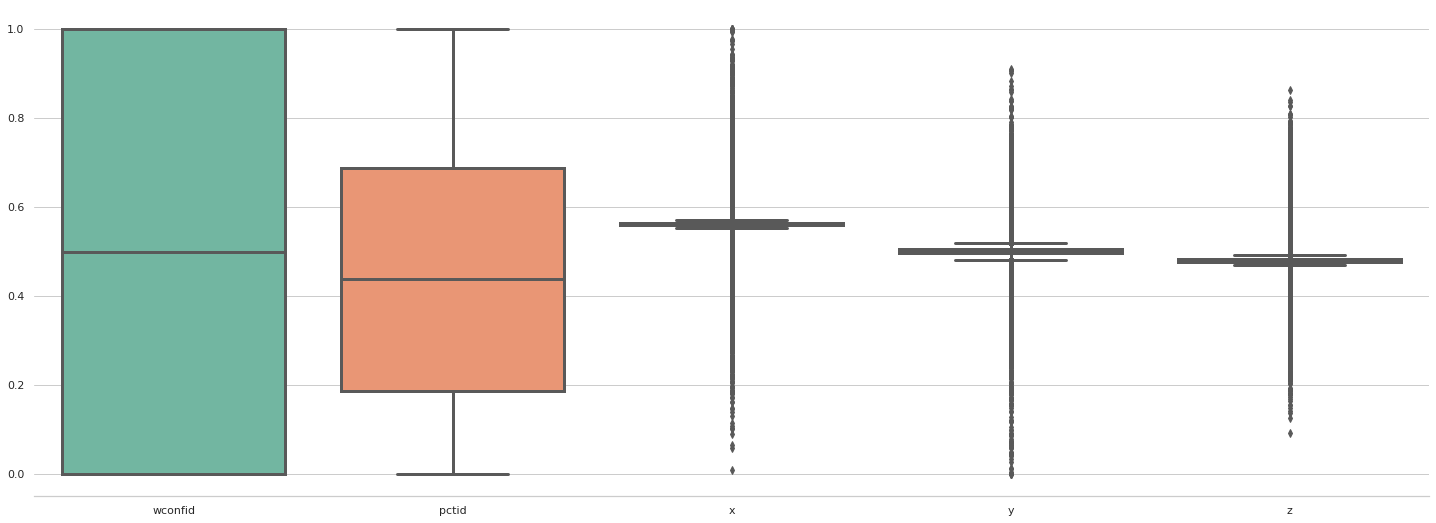

In [ ]:
sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = datos_sin_outliers_IQR, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

*Opción 2: Usando un taponamiento superior e inferior*

In [ ]:
Datos_taponados = Datos_Min_Max.copy()

Datos_taponados['x'] = np.where(Datos_taponados['x'] > Max_Limite[2], Max_Limite[2],
                                np.where(Datos_taponados['x'] < Min_Limite[2], Min_Limite[2], Datos_taponados['x']))

Datos_taponados['y'] = np.where(Datos_taponados['y'] > Max_Limite[3], Max_Limite[3],
                                np.where(Datos_taponados['y'] < Min_Limite[3], Min_Limite[3], Datos_taponados['y']))

Datos_taponados['z'] = np.where(Datos_taponados['z'] > Max_Limite[4], Max_Limite[4],
                                np.where(Datos_taponados['z'] < Min_Limite[4], Min_Limite[4], Datos_taponados['z']))

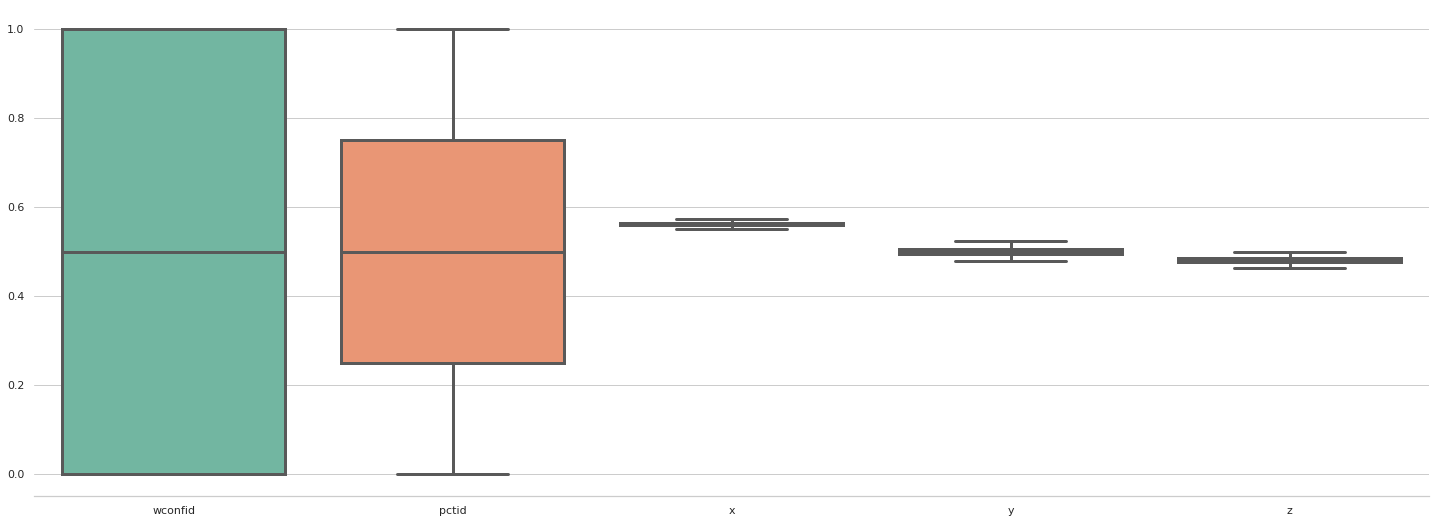

In [ ]:
sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = Datos_taponados, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

Comparemos los resultados de ambas opciones con la métrica de la entropía

In [ ]:
H_1 = entr(Datos_Min_Max[['x','y','z']])
H_2 = entr(datos_sin_outliers_IQR[['x','y','z']])
H_3 = entr(Datos_taponados[['x','y','z']])

entropia_normalizada_1 = H_1.sum()/Datos_Min_Max.shape[0]
entropia_normalizada_2 = H_2.sum()/datos_sin_outliers_IQR.shape[0]
entropia_normalizada_3 = H_3.sum()/Datos_taponados.shape[0]

entropia_normalizada_1 = pd.DataFrame(entropia_normalizada_1, index = None, columns = ['Entropia Original'])
entropia_normalizada_2 = pd.DataFrame(entropia_normalizada_2, index = None, columns = ['Entropia IQR'])
entropia_normalizada_3 = pd.DataFrame(entropia_normalizada_3, index = None, columns = ['Entropia IQR Taponado'])
Comparacion_entropias = pd.concat([entropia_normalizada_1, entropia_normalizada_2, entropia_normalizada_3], axis = 1)

display(Comparacion_entropias)

,Entropia Original,Entropia IQR,Entropia IQR Taponado
x,0.321535,0.322888,0.323757
y,0.344003,0.345610,0.346077
z,0.350070,0.351448,0.352000


## Test Z para Detección de Datos Atípicos

El test Z o puntuación estándar es un test estadístico que permite entender si un valor de los datos es mayor o menor que la media y a qué distancia está de la media. Lo anterior indica cuántas desviaciones estándar hay entre un punto de los datos y la media.

$z = \frac{x - \mu}{\sigma}$

siendo $x$ una columna de datos, $\mu$ es la media de la columna de datos y $\sigma$ es la desviación estándar de la columna de datos (observen que este concepto es exactamente igual al método de escalamiento estándar visto en la sesión anterior).

Para el caso de la detección de datos atípicos, se sugiere seguir la regla de las 3 desviaciones estándar:

1.   Si se considera el 68% de los datos dentro de una distribución normal, entonces se considera una desviación estándar más o menos de 1, es decir, $\mu \pm \sigma$
2.   Si se considera el 95% de los datos dentro de una distribución normal, entonces se considera una desviación estándar más o menos de 2, es decir, $\mu \pm 2\sigma$
3.   Si se considera el 99.7% de los datos dentro de una distribución normal, entonces se considera una desviación estándar más o menos de 2, es decir, $\mu \pm 3\sigma$

Por ejemplo, si la el valor $z$ de un dato es mayor a 3, esto nos indica que el dato es muy diferente de los demás datos, y por consiguiente, el dato puede ser un valor atípico.

In [ ]:
media = np.mean(Datos_Min_Max)
std = np.std(Datos_Min_Max)

print('media de las características de la base de datos: \n', media)
print('desviación estándar de las características de la base de datos: \n ', std)

media de las características de la base de datos: 
 wconfid    0.500000
pctid      0.500000
x          0.562367
y          0.500460
z          0.480986
dtype: float64
desviación estándar de las características de la base de datos: 
  wconfid    0.408248
pctid      0.306186
x          0.048384
y          0.046424
z          0.043253
dtype: float64


In [ ]:
regla_desviacion = 3
z = (Datos_Min_Max - media)/std
z.describe()

,wconfid,pctid,x,y,z
count,1.530000e+05,1.530000e+05,1.530000e+05,1.530000e+05,1.530000e+05
mean,4.755528e-17,-1.188882e-17,2.691703e-16,1.205647e-15,-9.709822e-16
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-1.224745e+00,-1.632993e+00,-1.162291e+01,-1.078018e+01,-1.112024e+01
25%,-1.224745e+00,-8.164966e-01,-6.540706e-02,-1.122427e-01,-1.048940e-01
50%,0.000000e+00,0.000000e+00,-4.680082e-03,3.566742e-03,-1.398598e-02
75%,1.224745e+00,8.164966e-01,5.604690e-02,1.341890e-01,1.001326e-01
max,1.224745e+00,1.632993e+00,9.044932e+00,1.076038e+01,1.199941e+01


**Notas**
- Las variables $x$, $y$ y $z$ poseen valores máximos por encima de 3

In [ ]:
datos_atipicos_wconfid = []
datos_atipicos_pctid = []
datos_atipicos_x = []
datos_atipicos_y = []
datos_atipicos_z = []

pos_atipicos_wconfid = []
pos_atipicos_pctid = []
pos_atipicos_x = []
pos_atipicos_y = []
pos_atipicos_z = []

for n in range(Datos_Min_Max.shape[0]):
    if z.iloc[n,0] > regla_desviacion:
      datos_atipicos_wconfid.append(Datos_Min_Max.iloc[n,0])
      pos_atipicos_wconfid.append(n)
    if z.iloc[n,1] > regla_desviacion:
      datos_atipicos_pctid.append(Datos_Min_Max.iloc[n,1])
      pos_atipicos_pctid.append(n)
    if z.iloc[n,2] > regla_desviacion:
      datos_atipicos_x.append(Datos_Min_Max.iloc[n,2])
      pos_atipicos_x.append(n) 
    if z.iloc[n,3] > regla_desviacion:
      datos_atipicos_y.append(Datos_Min_Max.iloc[n,3])
      pos_atipicos_y.append(n) 
    if z.iloc[n,4] > regla_desviacion:
      datos_atipicos_z.append(Datos_Min_Max.iloc[n,4])
      pos_atipicos_z.append(n)

Numero_datos_atipicos = [len(datos_atipicos_wconfid), len(datos_atipicos_pctid), len(datos_atipicos_x), 
                         len(datos_atipicos_y), len(datos_atipicos_z)]

reporte = pd.DataFrame(Numero_datos_atipicos, index = nombres, columns = ['Número de Datos Atípicos'])
display(reporte)  

,Número de Datos Atípicos
wconfid,0
pctid,0
x,2287
y,1827
z,2417


¿Cómo eliminar los datos atípicos si las columnas $x$, $y$, $z$, tienen diferentes número de datos atípicos? Una estrategía es localizar las posiciones donde coincidan los datos atípicos de las tres columnas mencionadas.

In [ ]:
Posiciones_coinciden = list(set(pos_atipicos_x) & set(pos_atipicos_y) & set(pos_atipicos_z))
print(Posiciones_coinciden)

[45573, 97414, 50952, 50826, 99598, 42513, 46098, 45842, 49553, 99219, 49823, 42145, 47011, 47523, 49322, 48298, 46510, 46128, 46262, 44984, 99514, 48829, 46412, 48717, 47956, 47060, 48736, 43107, 100336, 97655]


In [ ]:
datos_sin_outliers_z = Datos_Min_Max.drop(Posiciones_coinciden)
print(Datos_Min_Max.shape) # Tamaño de los datos originales
print(datos_sin_outliers_z.shape) # Tamañno de los datos sin outliers 

(153000, 5)
(152970, 5)


Verificando con la métrica de entropía

In [ ]:
H_1 = entr(Datos_Min_Max[['x','y','z']])
H_2 = entr(datos_sin_outliers_z[['x','y','z']])

entropia_normalizada_1 = H_1.sum()/Datos_Min_Max.shape[0]
entropia_normalizada_2 = H_2.sum()/datos_sin_outliers_z.shape[0]

entropia_normalizada_1 = pd.DataFrame(entropia_normalizada_1, index = None, columns = ['Entropia Original'])
entropia_normalizada_2 = pd.DataFrame(entropia_normalizada_2, index = None, columns = ['Entropia Z'])
Comparacion_entropias = pd.concat([entropia_normalizada_1, entropia_normalizada_2], axis = 1)

display(Comparacion_entropias)

,Entropia Original,Entropia Z
x,0.321535,0.321569
y,0.344003,0.344024
z,0.350070,0.350088


**Notas**
- Método poco sensible a los máximos -> datos en las regiones extremas
- Sin embargo, para evitar el problema de la poca sensibilidad, se propuso una modificación -> Test Z Modificado -> aumentar la sensibilidad para detectar datos atípicos en las regiones extremas
- $Z_{mod}$ = $\frac{0.6745(X-mediana)}{MAD}$
- $MAD$ = Median Absolute Deviation

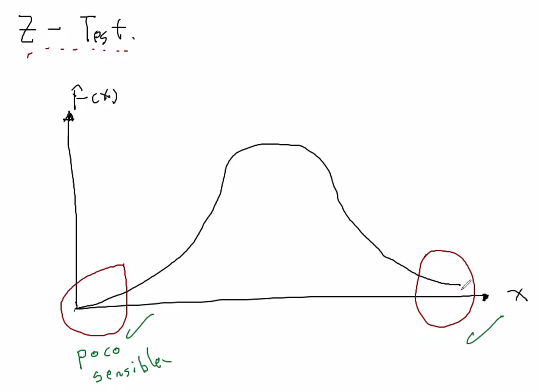

In [ ]:
from IPython.display import Image
Image(filename="z_test.png")

## Test Z Modificado para Detección de Datos Atípicos

El test Z modificado es una mejora del test Z clásico para mejorar la sensibilidad en la detección de datos atípicos. A diferencia del test Z, el test Z modificado cálcula la cantidad de desviaciones medias por debajo o por encima de la mediana de los datos, lo cual, permite detectar aquellos datos con mayor valor de $z$. Si el valor de $z$ es mayor, la desviación media de la mediana de los datos será mayor y permitirá detectar aquellos datos atípicos.

La fórmula para calcular el Test Z modificado es el siguiente:

$z_{mod} = 0.6745 \left (\frac{x-mediana}{MAD} \right )$

donde $MAD$ significa *Desviación Mediana Absoluta*, el cual reemplaza el cálculo de la desviación estándar del test Z clásico y el factor 0.6745 esta cercano a la regla 1 mencionado del test Z original. 

In [ ]:
mediana = np.median(Datos_Min_Max, axis = 0)
MAD = median_abs_deviation(Datos_Min_Max)

print('mediana de las características de la base de datos: \n', mediana)
print('\n')
print('MAD de las características de la base de datos: \n ', MAD)

mediana de las características de la base de datos: 
 [0.5        0.5        0.56214054 0.50062516 0.48038149]


MAD de las características de la base de datos: 
  [0.5        0.25       0.00293823 0.00562641 0.00460136]


In [ ]:
z_modificado = 0.6745*((Datos_Min_Max - mediana)/MAD)
z_modificado.describe()

,wconfid,pctid,x,y,z
count,1.530000e+05,1.530000e+05,153000.000000,153000.000000,153000.000000
mean,1.783323e-17,-1.188882e-17,0.051982,-0.019850,0.088676
std,5.507287e-01,8.260931e-01,11.107125,5.565387,6.340396
min,-6.745000e-01,-1.349000e+00,-129.044766,-60.015511,-70.417800
25%,-6.745000e-01,-6.745000e-01,-0.674500,-0.644522,-0.576391
50%,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
75%,6.745000e-01,6.745000e-01,0.674500,0.726961,0.723555
max,6.745000e-01,1.349000e+00,100.514851,59.865622,76.169445


In [ ]:
regla_desviacion = 3

datos_atipicos_wconfid = []
datos_atipicos_pctid = []
datos_atipicos_x = []
datos_atipicos_y = []
datos_atipicos_z = []

for n in range(Datos_Min_Max.shape[0]):
    if z_modificado.iloc[n,0] > regla_desviacion:
      datos_atipicos_wconfid.append(Datos_Min_Max.iloc[n,0])
    if z_modificado.iloc[n,1] > regla_desviacion:
      datos_atipicos_pctid.append(Datos_Min_Max.iloc[n,1])
    if z_modificado.iloc[n,2] > regla_desviacion:
      datos_atipicos_x.append(Datos_Min_Max.iloc[n,2]) 
    if z_modificado.iloc[n,3] > regla_desviacion:
      datos_atipicos_y.append(Datos_Min_Max.iloc[n,3])
    if z_modificado.iloc[n,4] > regla_desviacion:
      datos_atipicos_z.append(Datos_Min_Max.iloc[n,4])

Numero_datos_atipicos = [len(datos_atipicos_wconfid), len(datos_atipicos_pctid), len(datos_atipicos_x), 
                         len(datos_atipicos_y), len(datos_atipicos_z)]

reporte = pd.DataFrame(Numero_datos_atipicos, index = nombres, columns = ['Número de Datos Atípicos'])
display(reporte)  

,Número de Datos Atípicos
wconfid,0
pctid,0
x,18061
y,15114
z,19405


In [ ]:
pos_atipicos_x = []
pos_atipicos_y = []
pos_atipicos_z = []

for n in range(Datos_Min_Max.shape[0]):
  if z_modificado.iloc[n,2] > regla_desviacion:
    pos_atipicos_x.append(n)
  if z_modificado.iloc[n,3] > regla_desviacion:
    pos_atipicos_y.append(n)
  if z_modificado.iloc[n,4] > regla_desviacion:
    pos_atipicos_z.append(n)

Posiciones_coinciden = list(set(pos_atipicos_x) & set(pos_atipicos_y) & set(pos_atipicos_z))
print(Posiciones_coinciden)

[40960, 81922, 49161, 49167, 90129, 49170, 98323, 49174, 49178, 90154, 41003, 49200, 49214, 41023, 49215, 98373, 90182, 98379, 41040, 82000, 41044, 90202, 41055, 98415, 41071, 98426, 98429, 41085, 49279, 98432, 90251, 90258, 49299, 98452, 90262, 49315, 98470, 49319, 49322, 49331, 90292, 49334, 41150, 41154, 32963, 49347, 98502, 49352, 49360, 90325, 32986, 98523, 98526, 41182, 49374, 98532, 90343, 41192, 33018, 90374, 49416, 98573, 49427, 41237, 98584, 98585, 41241, 98588, 41245, 49438, 90398, 98594, 33062, 49449, 41258, 49451, 41260, 98612, 33088, 98628, 41284, 41286, 49477, 49481, 82260, 49506, 90468, 98662, 98666, 90475, 41325, 49523, 33144, 49532, 90492, 90500, 98693, 49545, 90506, 41358, 98705, 49553, 49555, 98708, 49559, 49561, 90523, 49570, 90530, 98726, 90550, 41407, 98752, 41408, 90567, 33226, 41419, 90578, 41435, 33244, 98781, 98782, 41436, 41438, 41441, 98788, 90598, 33256, 41451, 49644, 98797, 98806, 49655, 98819, 41477, 49669, 90632, 98827, 90638, 41492, 49685, 90646, 90649

In [ ]:
datos_sin_outliers_z_modificado = Datos_Min_Max.drop(Posiciones_coinciden)
print(Datos_Min_Max.shape) # Tamaño de los datos originales
print(datos_sin_outliers_z_modificado.shape) # Tamañno de los datos sin outliers

(153000, 5)
(151025, 5)


In [ ]:
print("Número de datos atípicos eliminados = ", Datos_Min_Max.shape[0] - datos_sin_outliers_z_modificado.shape[0])

Número de datos atípicos eliminados =  1975


In [ ]:
H_1 = entr(Datos_Min_Max[['x','y','z']])
H_2 = entr(datos_sin_outliers_z_modificado[['x','y','z']])

entropia_normalizada_1 = H_1.sum()/Datos_Min_Max.shape[0]
entropia_normalizada_2 = H_2.sum()/datos_sin_outliers_z_modificado.shape[0]

entropia_normalizada_1 = pd.DataFrame(entropia_normalizada_1, index = None, columns = ['Entropia Original'])
entropia_normalizada_2 = pd.DataFrame(entropia_normalizada_2, index = None, columns = ['Entropia Z Modificado'])
Comparacion_entropias = pd.concat([entropia_normalizada_1, entropia_normalizada_2], axis = 1)

display(Comparacion_entropias)

,Entropia Original,Entropia Z Modificado
x,0.321535,0.322130
y,0.344003,0.344441
z,0.350070,0.350482


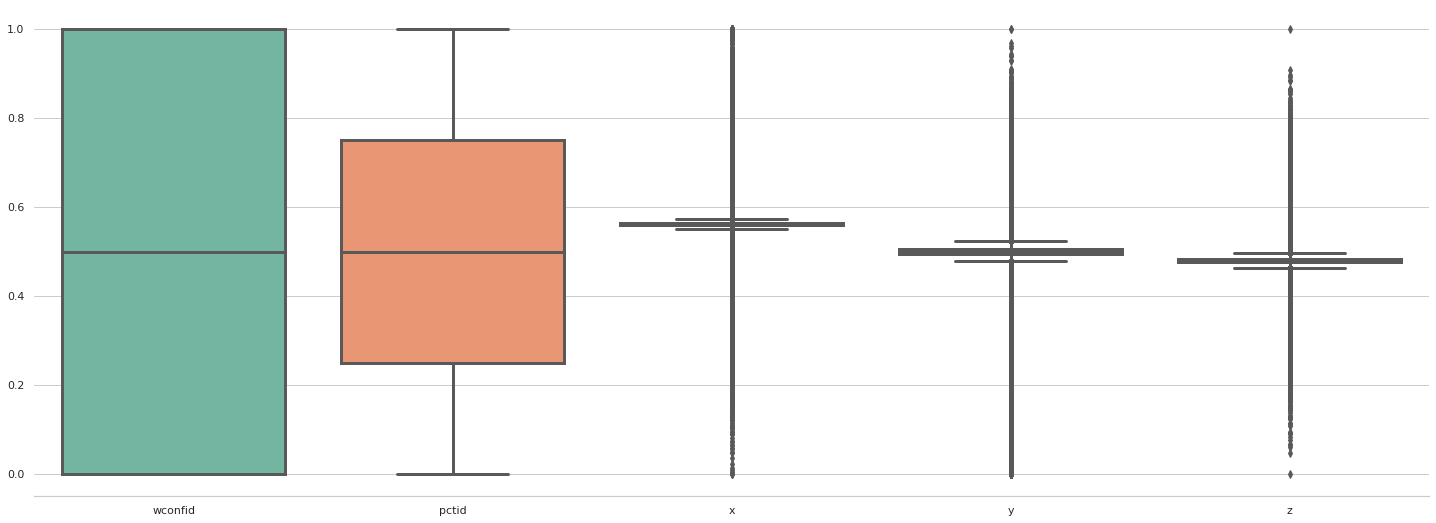

In [ ]:
sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = datos_sin_outliers_z_modificado, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

## Detección de Datos Atípicos con Estimación de Covarianza basado en una distribución multidimensional Gaussiana

Este método considera una detección de datos atípicos basado en una distribución de densidad de probabilidad multidimensional Gaussiana. 

Para comprender este método, vamos a dar una breve explicación de la densidad de probabilidad Gaussiana multivariada:

**Definición:** Dado un vector aleatorio de N-dimensiones, $X = \lbrack x_1, \ldots, x_N \rbrack$ sujeto a una distribución Gaussiana de N-dimensiones,$X \sim N(\mu, \Sigma)$, con parámetros ($\mu$,$\Sigma$), la función de densidad de probabilidad se expresa como:

$$f(x\vert \mu, \Sigma) = \frac{1}{(2\pi)^\frac{D}{2}\vert\Sigma \vert^\frac{1}{2}} \exp \left \lbrack -\frac{1}{2}(x - \mu)^T \Sigma^{-1} (x - \mu)\right \rbrack$$

donde:

1.   $D$ es el número de dimensiones.
2.   $\mu$ es el vector de la media, donde la esperanza matemática es $E(X) = \mu$
3.   $ Cov(X) = \Sigma$ es la matriz de covarianza de los datos.

$$\Sigma = \begin{bmatrix} \sigma_{1,1} & \cdots &\sigma_{1,d} & \cdots & \sigma_{1,D}\\
\vdots & \ddots & \vdots & \cdots & \vdots\\
\sigma_{d,1} & \cdots &\sigma_{d,d} & \cdots & \sigma_{d,D}\\
\vdots & \ddots & \vdots & \cdots & \vdots\\
\sigma_{D,1} & \cdots &\sigma_{D,d} & \cdots & \sigma_{D,D}\\\end{bmatrix}_{DxD}$$

Siendo $\sigma_{d,d}$ la covarianza de una dimensión $d$ con respecto a otra dimensión $d$, considerando:

$$\sigma_{i,j} = E(X_i - \mu_i)(X_j - \mu_j) = E(X_i X_j) - \mu_i\mu_j$$

Y la varianza por cada muestra $X_i$:

$$\sigma_{i,i} = E(X_i - \mu_i)^2 = E(X_i^2) - \mu_i^2$$

4.   $\vert \cdot \vert$ es el operador determinante de la matriz.
5.   $\Sigma^{-1}$ es la pseudo-inversa de la matriz de covarianza de los datos.
6.   $\frac{1}{2}(x - \mu)^T \Sigma^{-1} (x - \mu)$ es una forma cuadrática.   

Para determinar la la función de densidad de probabilidad, se estima los dos parámetros $(\mu, \Sigma)$, el cual se expresa como:

$$\hat{\mu} = \frac{1}{N} \sum_{n=1}^N x_{n}$$
$$\Sigma = \sum_{n=1}^N (x_{n} - \hat{\mu})^T (x_{n} - \hat{\mu})$$

**Nota:** La función de probabilidad Gaussiana de una dimensión se considera como un caso especial de la función de probabilidad Gaussiana multivariable.

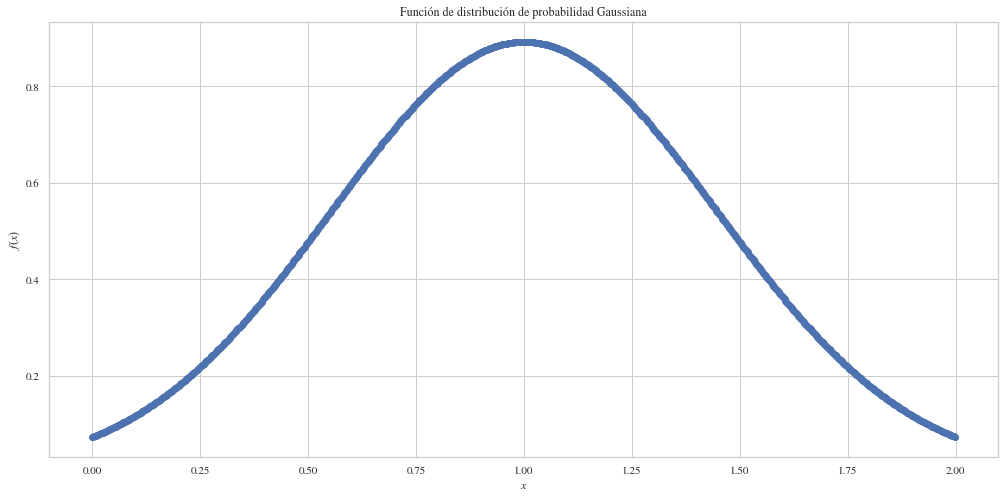

In [ ]:
matplotlib.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

x = np.linspace(0, 2, 1000, endpoint = False)
f = multivariate_normal.pdf(x, mean = 1, cov = 0.2)

fig = plt.figure(figsize=(17,8))
plt.plot(x, f, '-o')
plt.xlabel('$x$') # Etiqueta del eje x 
                   # $ es para escribir símbolos en LaTeX
plt.ylabel('$f(x)$') # Etiqueta del eje y
plt.title('Función de distribución de probabilidad Gaussiana')
plt.show()

La matriz de covarianza $\Sigma$ tiene muchas implicaciones la forma como construimos una distribución de probabilidad Gaussiana Multivariada, lo cual, en aplicaciones en Machine Learning tiene muchas implicaciones en la forma como analizamos la distribución natural de los datos. Considerando lo anterior, vamos a observar tres casos de la matriz de covarianza $\Sigma$

rimero, vamos a definir la matriz de covarianza desde el punto de vista matemático:

$$\Sigma = \begin{bmatrix} \Sigma_{x} & \Sigma_{xy} \\ \Sigma_{xy}^T & \Sigma_{y}\end{bmatrix}$$

donde $x$ e $y$ son dos variables aleatorias y $\Sigma^T$ es la transpuesta de la matriz.

Por otra parte, se debe considerar un vector de medias, donde cada media esta relacionado con una variable aleatoria:

$$\mu =  \begin{bmatrix} \mu_x\\ \mu_y \end{bmatrix}$$

**Matriz de Covarianza Completa:** 

Los datos se agrupan en forma parabólica.

$$f(x,y) = \mathcal{N} \begin{pmatrix} \begin{bmatrix} 0\\ 0\end{bmatrix}, \begin{bmatrix} 1 & -1 \\ -1 & 4\end{bmatrix} \end{pmatrix}$$

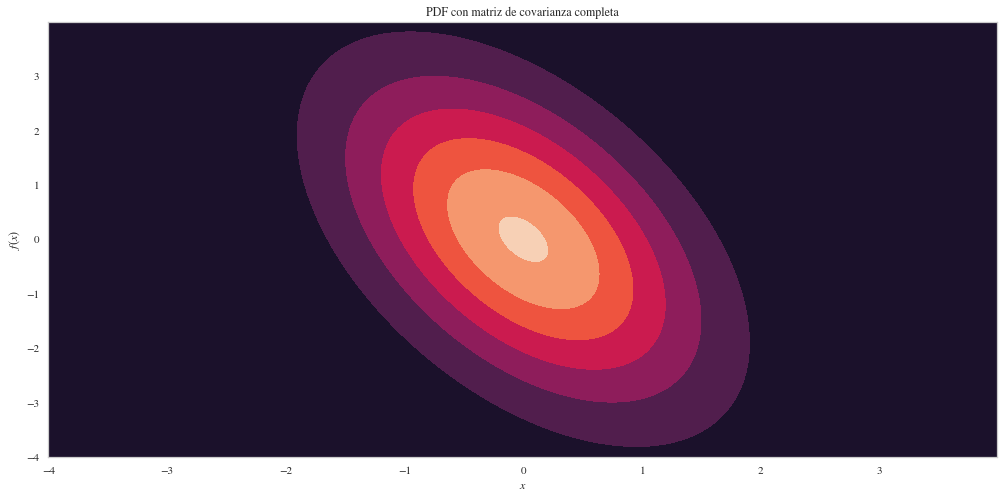

In [ ]:
matplotlib.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

x, y = np.mgrid[-4:4:0.01, -4:4:0.01]
pos = np.dstack((x, y))
rv = multivariate_normal([0, 0], [[1, -1], [-1, 4]])
fig = plt.figure(figsize=(17,8))
ax2 = fig.add_subplot(111)
ax2.contourf(x, y, rv.pdf(pos)) # Genera una gráfica de contonor
plt.xlabel('$x$') # Etiqueta del eje x
plt.ylabel('$f(x)$') # Etiqueta del eje y
plt.title('PDF con matriz de covarianza completa')
plt.show()

**Matriz de Covarianza Esférica:** 

Los datos se agrupan de forma circular de acuerdo a los valores de la media, generando hiperesferas. Lo anterior genera un único valor de la varianza para todos los datos.

$$f(x,y) = \mathcal{N} \begin{pmatrix} \begin{bmatrix} 0\\ 0\end{bmatrix}, \begin{bmatrix} 1 & 0 \\ 0 & 1\end{bmatrix} \end{pmatrix}$$

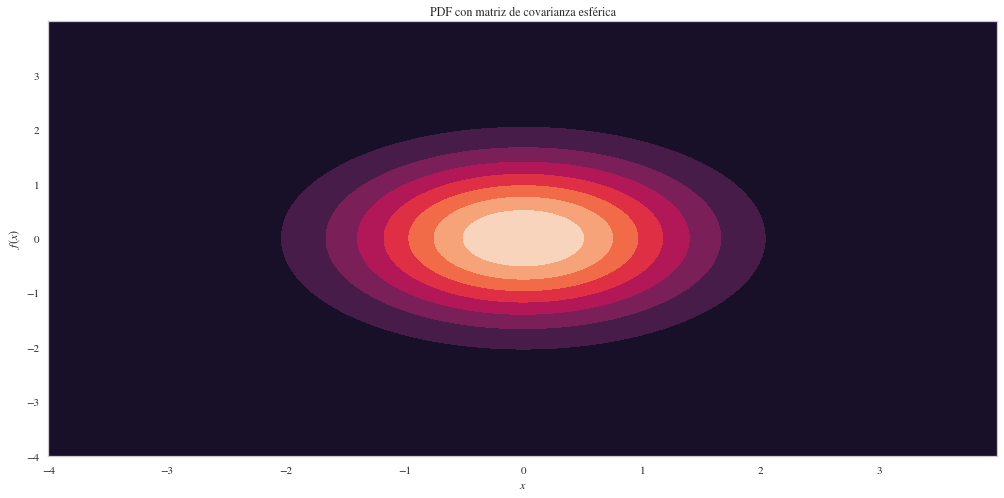

In [ ]:
matplotlib.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

x, y = np.mgrid[-4:4:0.01, -4:4:0.01]
pos = np.dstack((x, y))
plt.figure(figsize=(17,8))
rv_3 = multivariate_normal([0, 0], [[1, 0], [0, 1]])
plt.contourf(x, y, rv_3.pdf(pos))
plt.xlabel('$x$') # Etiqueta del eje x
plt.ylabel('$f(x)$') # Etiqueta del eje y
plt.title('PDF con matriz de covarianza esférica')
plt.show()

**Matriz de Covarianza Diagonal:** 

Los datos se agrupan de forma elíptica, generando hiperelipsoides donde $\Sigma$ contiene valores distintos en su diagonal.

$$f(x,y) = \mathcal{N} \begin{pmatrix} \begin{bmatrix} 0\\ 0\end{bmatrix}, \begin{bmatrix} 1 & 0 \\ 0 & 4\end{bmatrix} \end{pmatrix}$$

En este caso, los datos se agrupan en elipses en paralelo a un eje.

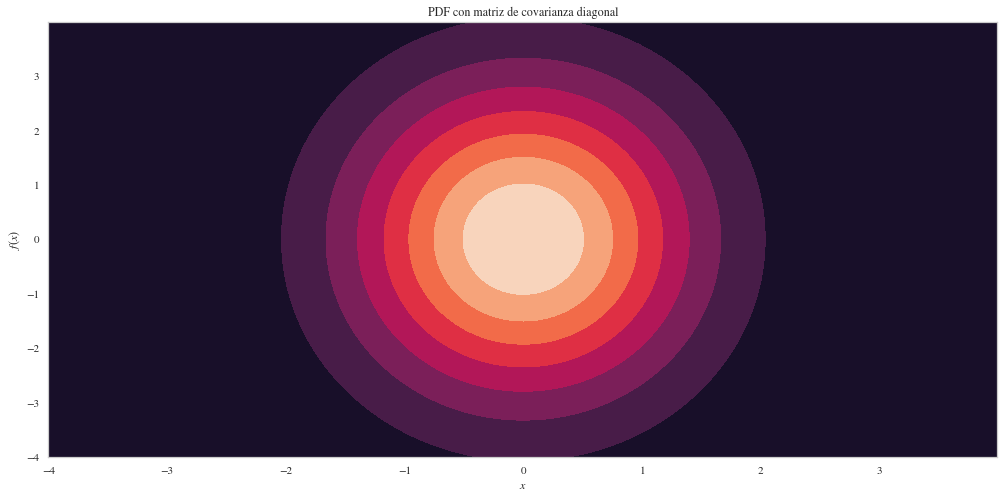

In [ ]:
matplotlib.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

x, y = np.mgrid[-4:4:0.01, -4:4:0.01]
pos = np.dstack((x, y))
plt.figure(figsize=(17,8))
rv_2 = multivariate_normal([0, 0], [[1, 0], [0, 4]])
plt.contourf(x, y, rv_2.pdf(pos))
plt.xlabel('$x$') # Etiqueta del eje x
plt.ylabel('$f(x)$') # Etiqueta del eje y
plt.title('PDF con matriz de covarianza diagonal')
plt.show()

Teniendo presente estos conceptos de la función Gaussiana multivariada, vamos a aplicar la estimación de covarianza con dicha distribución para detectar datos atípicos:

Primer se aplica la regla de detección para determinar si es pertinente o no aplicar el método con nuestro datos:

In [ ]:
Muestras = Datos_Min_Max.shape[0]
Caracteristicas_Cuadradas = (Datos_Min_Max.shape[1])**2

if Muestras > Caracteristicas_Cuadradas:
  print("Se puede aplicar el método de estimación de covarianza con una distribución gaussiana multivariada")
if Muestras < Caracteristicas_Cuadradas:
  print("No se puede aplicar el método de estimación de covarianza con una distribución gaussiana multivariada")

Se puede aplicar el método de estimación de covarianza con una distribución gaussiana multivariada


Ahora, vamos a estimar la covarianza de nuestros datos:

In [ ]:
EE = EllipticEnvelope(contamination = 0.05) # 5% de Datos Atípicos
estimacion_covarianza = EE.fit(Datos_Min_Max)

In [ ]:
estimacion_covarianza.covariance_ # Matrices de covarianza

array([[ 1.69893680e-01,  3.92531473e-02, -3.59439729e-05,
         3.68215863e-05, -1.68742667e-05],
       [ 3.92531473e-02,  6.29250741e-02, -3.31780003e-05,
         1.60941739e-04,  3.58304274e-06],
       [-3.59439729e-05, -3.31780003e-05,  9.30127433e-06,
         9.99824666e-07, -6.88494859e-08],
       [ 3.68215863e-05,  1.60941739e-04,  9.99824666e-07,
         3.49807568e-05, -7.09940409e-07],
       [-1.68742667e-05,  3.58304274e-06, -6.88494859e-08,
        -7.09940409e-07,  2.01301415e-05]])

In [ ]:
Estimacion_Muestras = estimacion_covarianza.predict(Datos_Min_Max)
print(Estimacion_Muestras) # si hay -1, es un dato atípico

[1 1 1 ... 1 1 1]


In [ ]:
Deteccion = np.where(Estimacion_Muestras == -1)
print("Número de Filas con Datos Atípicos = ", pd.DataFrame(Deteccion).shape[1])

Número de Filas con Datos Atípicos =  7650


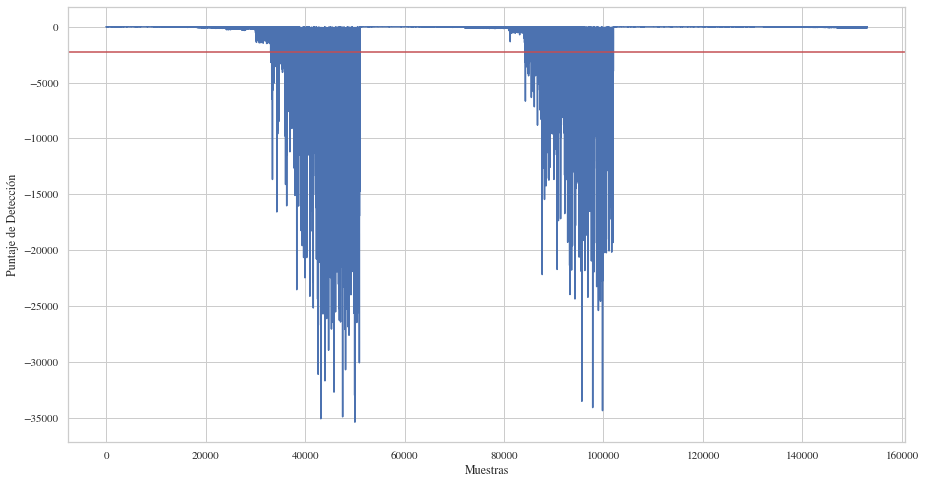

In [ ]:
puntajes = estimacion_covarianza.score_samples(Datos_Min_Max)
umbral = estimacion_covarianza.offset_

plt.figure(figsize=(15,8))
plt.plot(np.arange(0,puntajes.shape[0],1), puntajes)
plt.axhline(umbral, color = 'r')
plt.xlabel('Muestras')
plt.ylabel('Puntaje de Detección')
plt.show()

In [ ]:
pos = np.where(Estimacion_Muestras == 1) 
# Se identifican en que muestras o filas de nuestra base de datos hay presencia de datos atípicos
pos = np.asarray(pos)
pos = np.hstack(pos)
datos_sin_outilers_EC = Datos_Min_Max.loc[pos, :]
print("Número de muestras sin outilers:", datos_sin_outilers_EC.shape[0])

Número de muestras sin outilers: 145350


In [ ]:
print(Datos_Min_Max.shape) # Tamaño de los datos originales
print(datos_sin_outilers_EC.shape) # Tamañno de los datos sin outliers 

(153000, 5)
(145350, 5)


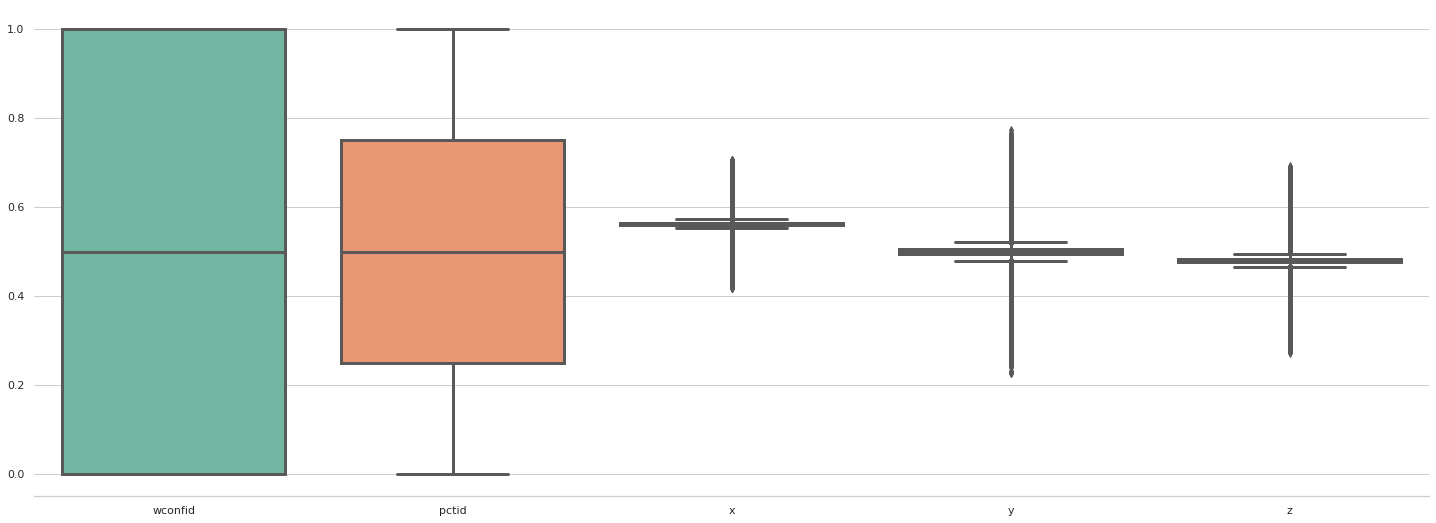

In [ ]:
sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = datos_sin_outilers_EC, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

In [ ]:
H_1 = entr(Datos_Min_Max[['x','y','z']])
H_2 = entr(datos_sin_outilers_EC[['x','y','z']])

entropia_normalizada_1 = H_1.sum()/Datos_Min_Max.shape[0]
entropia_normalizada_2 = H_2.sum()/datos_sin_outilers_EC.shape[0]

entropia_normalizada_1 = pd.DataFrame(entropia_normalizada_1, index = None, columns = ['Entropia Original'])
entropia_normalizada_2 = pd.DataFrame(entropia_normalizada_2, index = None, columns = ['Entropia EC'])
Comparacion_entropias = pd.concat([entropia_normalizada_1, entropia_normalizada_2], axis = 1)

display(Comparacion_entropias)

,Entropia Original,Entropia EC
x,0.321535,0.323184
y,0.344003,0.345183
z,0.350070,0.351184


### Eliminación de Datos atípicos con estimación de covarianza usando taponamiento

In [ ]:
pos_outliers = np.where(Estimacion_Muestras == -1)
pos_s = pd.DataFrame(pos_outliers)
IQR = iqr(datos_sin_outilers_EC, axis = 0, rng = (25, 75), interpolation = 'midpoint')
print(IQR)

[1.         0.5        0.00512628 0.01075269 0.00752949]


In [ ]:
Q1 = np.percentile(datos_sin_outilers_EC, 25, axis = 0, interpolation = 'midpoint')
Q3 = np.percentile(datos_sin_outilers_EC, 75, axis = 0, interpolation = 'midpoint')

Min_Limite = Q1 - 1.5*IQR
Max_Limite = Q3 + 1.5*IQR

print("Límites inferiores = ", Min_Limite)
print("\n")
print("Límites superiores = ", Max_Limite)

Límites inferiores =  [-1.5        -0.5         0.552013    0.4796199   0.46582448]


Límites superiores =  [2.5        1.5        0.57251813 0.52263066 0.49594244]


In [ ]:
Datos_taponados_N = Datos_Min_Max.copy()

D1 = np.where(Datos_taponados_N.loc[pos_outliers,'x'] > Max_Limite[2], Max_Limite[2],
                                np.where(Datos_taponados_N.loc[pos_outliers,'x'] < Min_Limite[2], Min_Limite[2], 
                                         Datos_taponados_N.loc[pos_outliers,'x']))

D2 = np.where(Datos_taponados_N.loc[pos_outliers,'y'] > Max_Limite[3], Max_Limite[3],
                                np.where(Datos_taponados_N.loc[pos_outliers,'y'] < Min_Limite[3], Min_Limite[3], 
                                         Datos_taponados_N.loc[pos_outliers,'y']))

D3 = np.where(Datos_taponados_N.loc[pos_outliers,'z'] > Max_Limite[4], Max_Limite[4],
                                np.where(Datos_taponados_N.loc[pos_outliers,'z'] < Min_Limite[4], Min_Limite[4], 
                                         Datos_taponados_N.loc[pos_outliers,'z']))
A1 = Datos_taponados_N.loc[pos_outliers,'wconfid']
A2 = Datos_taponados_N.loc[pos_outliers,'pctid']

concatenar = np.vstack([pos_s, A1, A2, D1, D2, D3]).transpose()
concatenar = pd.DataFrame(concatenar, index = None, columns = ['pos','wconfid', 'pctid', 'x','y','z'])
concatenar['pos'] = concatenar['pos'].astype(int)
concatenar.set_index(['pos'], inplace=True)
concatenar.index.name = None
display(concatenar)

,wconfid,pctid,x,y,z
33084,0.0,0.6875,0.572518,0.479620,0.495942
33110,0.0,0.6875,0.572518,0.479620,0.495942
33123,0.0,0.6875,0.572518,0.479620,0.471262
33136,0.0,0.6875,0.572518,0.479620,0.477453
33235,0.0,0.6875,0.564329,0.479620,0.465824
...,...,...,...,...,...
101960,0.5,1.0000,0.572518,0.479620,0.483979
101965,0.5,1.0000,0.552013,0.522631,0.495942
101986,0.5,1.0000,0.572518,0.479620,0.495942
101987,0.5,1.0000,0.572518,0.479620,0.495942


In [ ]:
 Datos_taponados_N.iloc[pos_outliers] = concatenar.loc[pos_outliers] # Reemplazamos los nuevos valores

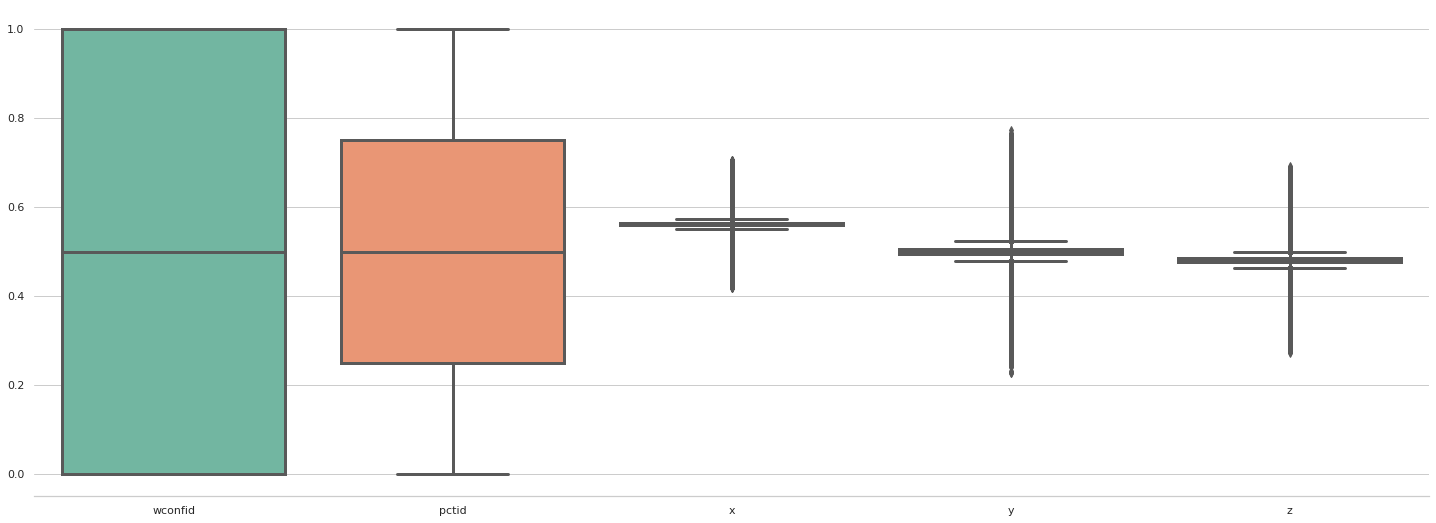

In [ ]:
sns.set(rc={'figure.figsize':(25,9)}) # Tamaño de la figura
sns.set(style="whitegrid") # Estilo de la figura
sns.boxplot(data = Datos_taponados_N, linewidth = 3, palette="Set2", fliersize = 5) # Diagrama Box Plot
sns.despine(left=True)

In [ ]:
H_1 = entr(Datos_Min_Max[['x','y','z']])
H_2 = entr(Datos_taponados_N[['x','y','z']])

entropia_normalizada_1 = H_1.sum()/Datos_Min_Max.shape[0]
entropia_normalizada_2 = H_2.sum()/Datos_taponados_N.shape[0]

entropia_normalizada_1 = pd.DataFrame(entropia_normalizada_1, index = None, columns = ['Entropia Original'])
entropia_normalizada_2 = pd.DataFrame(entropia_normalizada_2, index = None, columns = ['Entropia EC Taponado'])
Comparacion_entropias = pd.concat([entropia_normalizada_1, entropia_normalizada_2], axis = 1)

display(Comparacion_entropias)

,Entropia Original,Entropia EC Taponado
x,0.321535,0.323203
y,0.344003,0.345233
z,0.350070,0.351211
